In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
data = pd.read_csv('registration1d.csv', delimiter = ';', index_col = ['date'], parse_dates = ['date'])
data.head(10)

,registeredUsers
date,
2019-01-01,990
2019-01-02,1081
2019-01-03,947
2019-01-04,847
2019-01-05,821
2019-01-06,998
2019-01-07,886
2019-01-08,734
2019-01-09,806


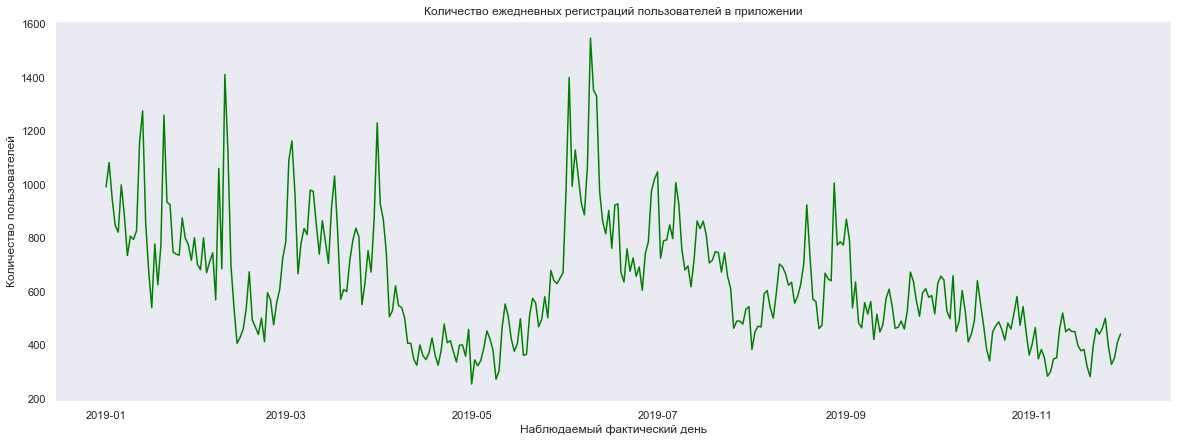

In [18]:
plt.figure(figsize = (20, 7))
plt.plot(data.registeredUsers, color = 'green')
plt.title('Количество ежедневных регистраций пользователей в приложении')
plt.ylabel('Количество пользователей')
plt.xlabel('Наблюдаемый фактический день')
plt.grid(False)
plt.show();

In [28]:
# Использование скользящей средней для сглаживания данных
def plot_moving_average(series, window, plot_intervals = False, scale = 1.96):
    
    rolling_mean = series.rolling(window = window).mean()
    
    plt.figure(figsize = (20, 9))
    plt.title('Скользящее среднее\n дистрибутивное окно = {} дней'.format(window))
    plt.plot(rolling_mean, 'g', label = 'Тренд скользящей средней')
    
    # Формирование доверительных интервалов для сглаженных данных
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label = 'Верхняя граница / Нижняя граница интервала')
        plt.plot(lower_bound, 'r--')
        
    plt.plot(series[window:], label = 'Фактические значения наблюдаемой величины')
    plt.legend(loc = 'best')
    plt.grid(True)
    

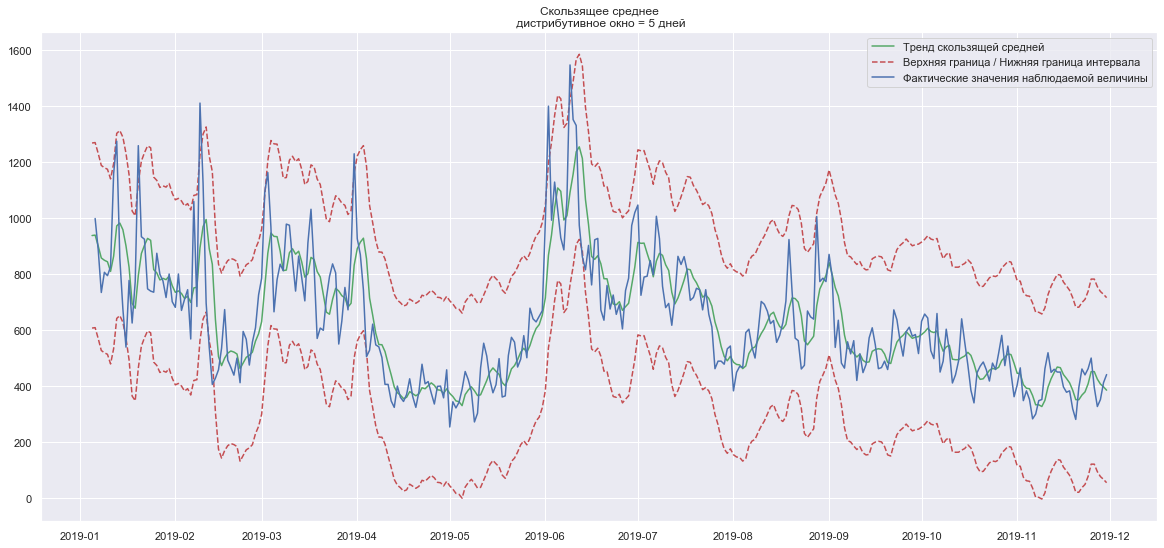

In [29]:
# Сглаживание на 7 предыдущих дней (1 неделя)
plot_moving_average(data.registeredUsers, 5, plot_intervals = True)

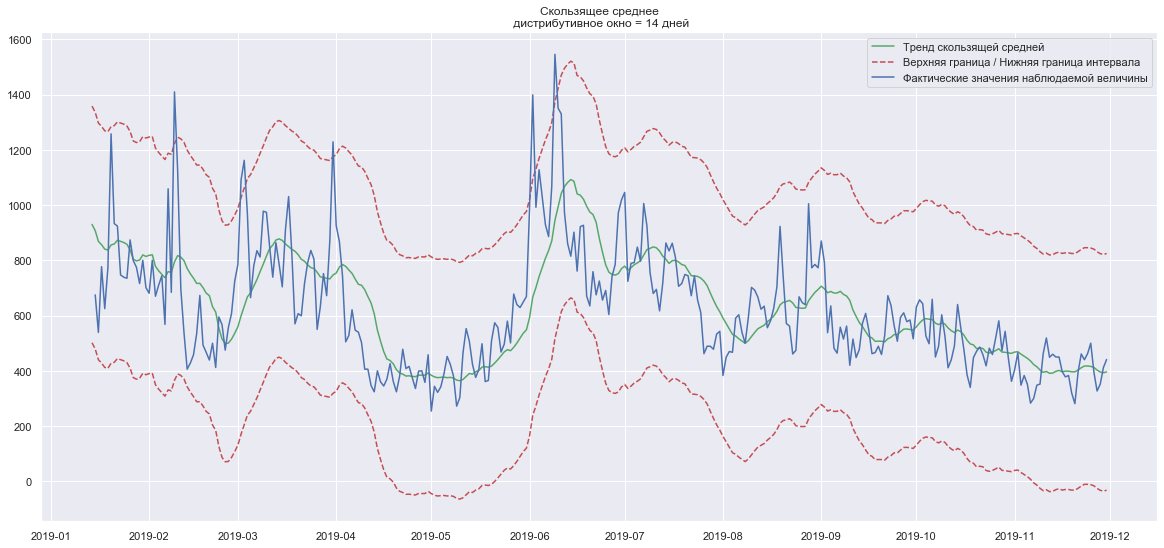

In [30]:
# Сглаживание на 14 предыдущих дней (2 недели)
plot_moving_average(data.registeredUsers, 14, plot_intervals = True)

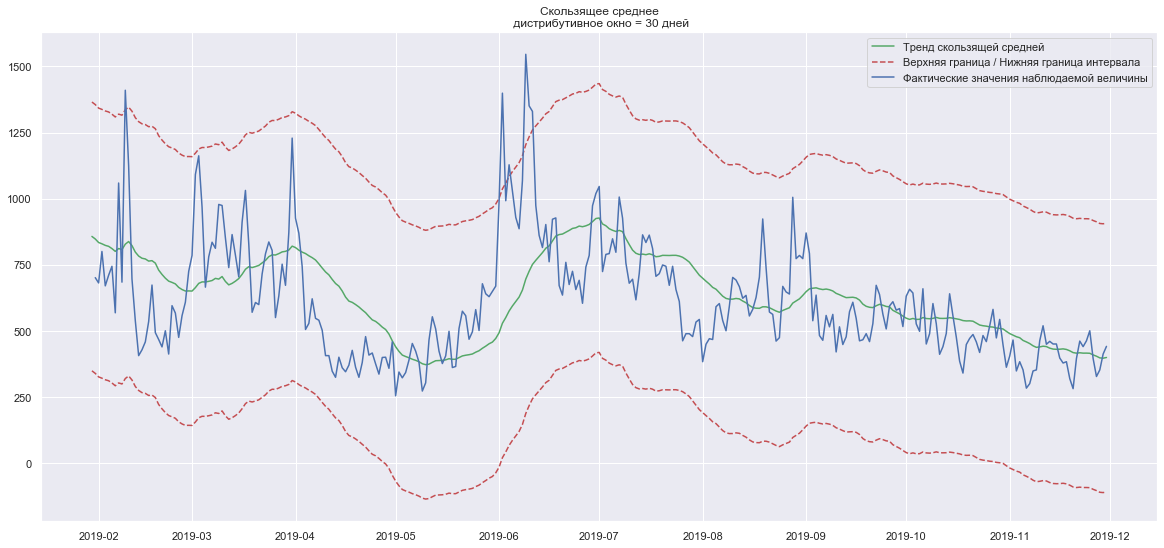

In [31]:
# Сглаживание на 1 месяц назад, для выявления тренда / тенденции
plot_moving_average(data.registeredUsers, 30, plot_intervals = True)


In [37]:
# Реализация экспоненциального сглаживания для наблюдаемых величин
def exponential_smoothing(series, alpha):
    
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

def plot_exponential_smoothing(series, alphas):
    
    plt.figure(figsize = (20, 9))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label = 'Alpha {}'.format(alpha))
    plt.plot(series.values, 'c', label = 'Фактические наблюдаемые значения')
    plt.legend(loc = 'best')
    plt.axis('tight')
    plt.title('Экспоненциальное сглаживание')
    plt.grid(True);


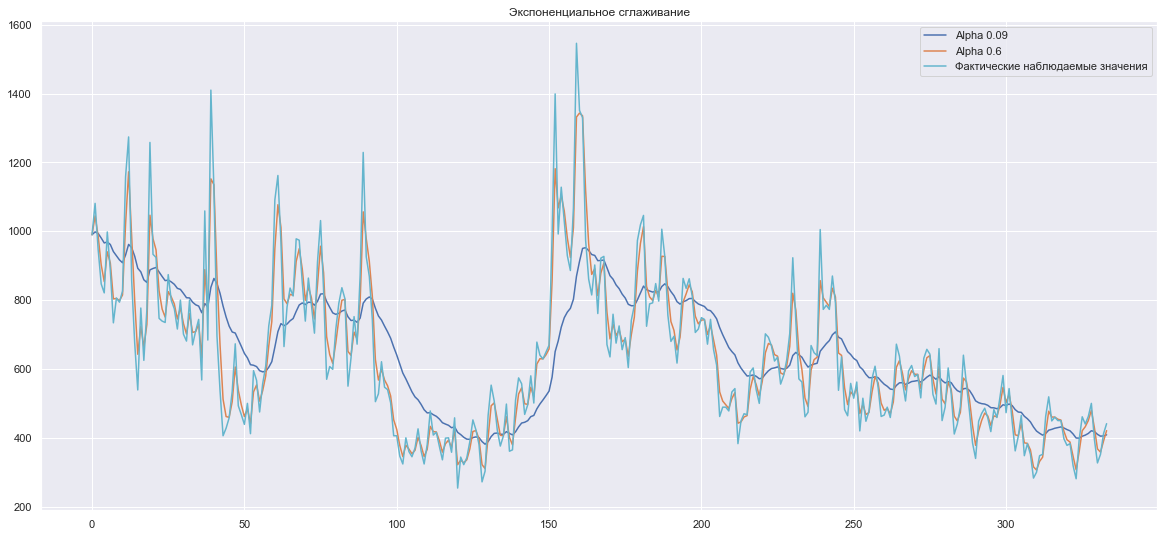

In [48]:
plot_exponential_smoothing(data.registeredUsers, [0.09, 0.6])

In [49]:
# Двойное экспоненциальное сглаживание
def double_exponential_smoothing(series, alpha, beta):
    
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): 
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    
    plt.figure(figsize = (20, 9))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label = 'Alpha {} , beta {}'.format(alpha, beta))
    plt.plot(series.values, label = 'Фактические наблюдаемые величины')
    plt.legend(loc = 'best')
    plt.axis('tight')
    plt.title('Двойное экспоненциальное сглаживание')
    plt.grid(True)


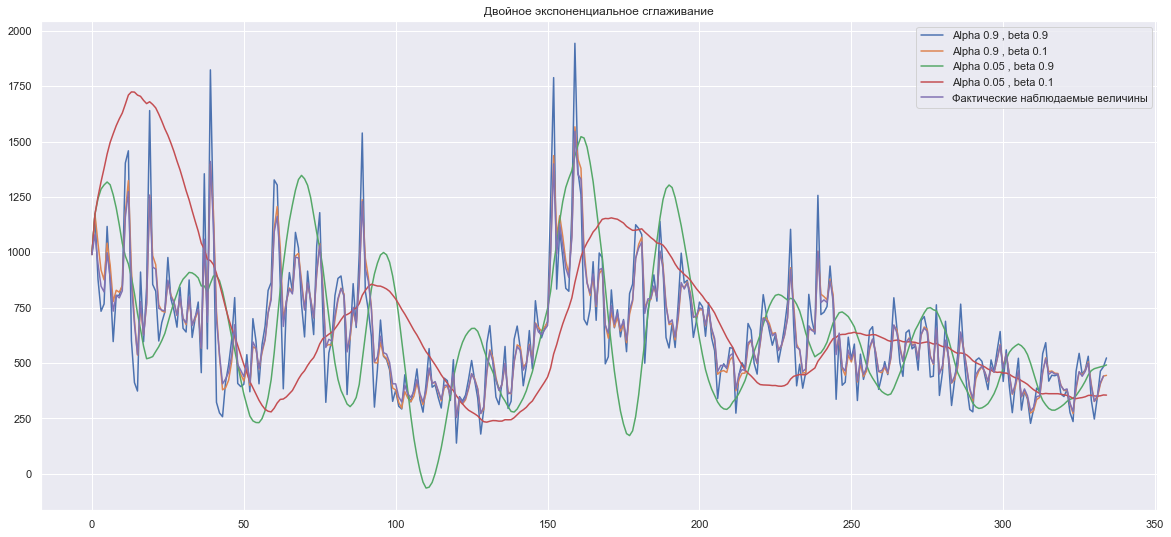

In [69]:
plot_double_exponential_smoothing(data.registeredUsers, alphas = [0.9, 0.05], betas = [0.9, 0.1])

In [71]:
# Проверка на стационарность временного ряда 
def tsplot(y, lags = None, figsize = (20, 9), syle = 'bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style = 'bmh'):
        fig = plt.figure(figsize = figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax = ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Временной ряд\n Dickey-Fuller Test: p = {0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags = lags, ax = acf_ax)
        smt.graphics.plot_pacf(y, lags = lags, ax = pacf_ax)
        plt.tight_layout()

#### Временной ряд для наблюдаемых величин  с лагом 7 дней является не стационарным

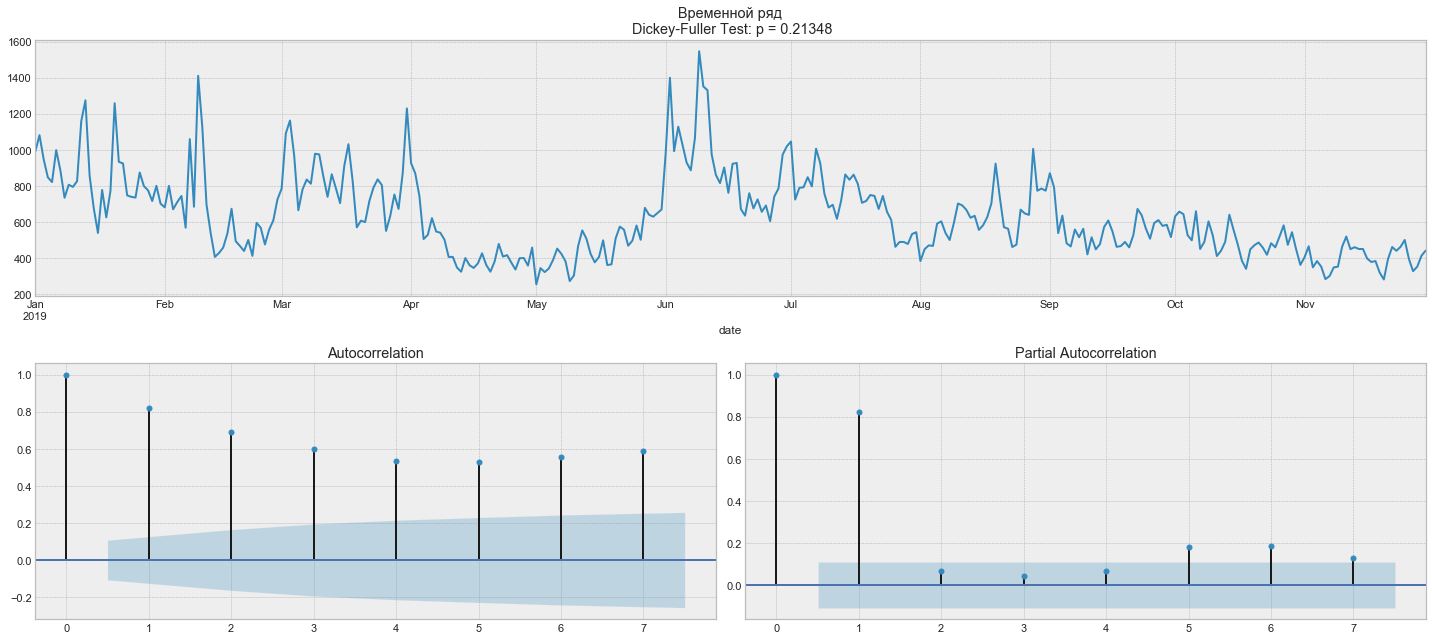

In [72]:
# Тест Дики-Фуллера на стационарность временного ряда, временной лаг 7 дней
tsplot(data.registeredUsers, lags = 7)

#### Временной ряд для наблюдаемых величин  с лагом 14 дней является не стационарным

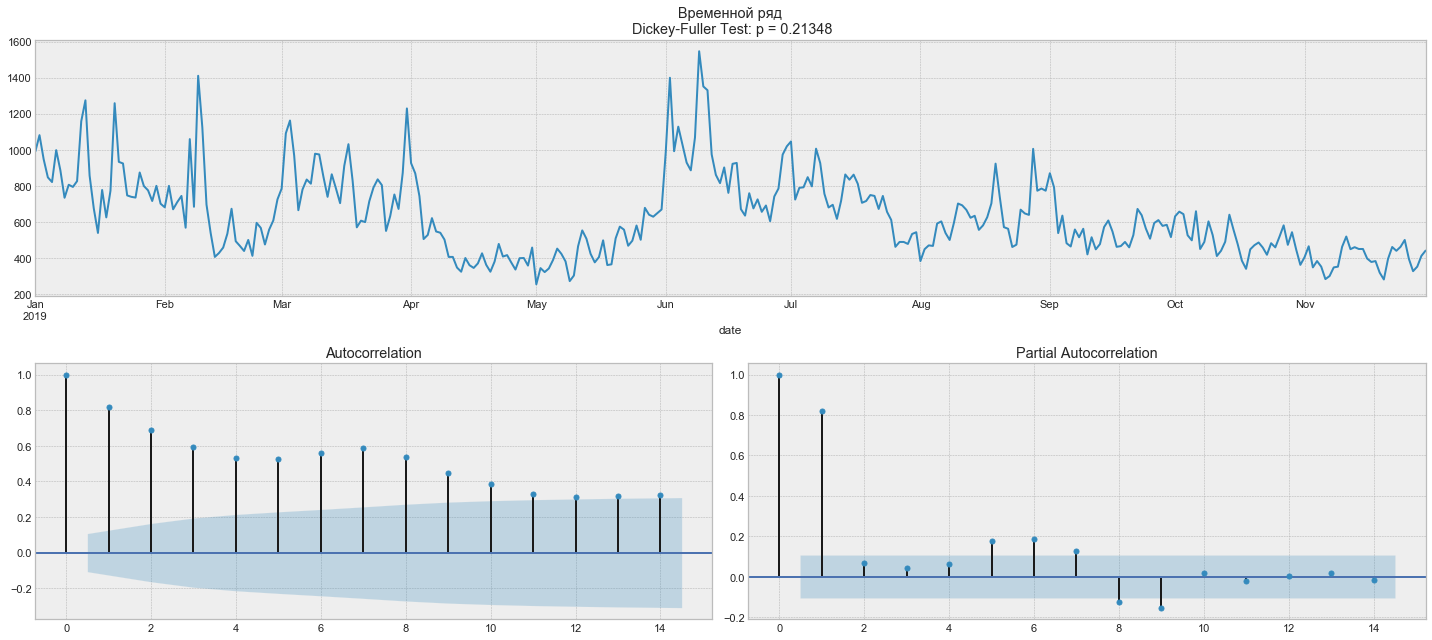

In [73]:
# Тест Дики-Фуллера на стационарность временного ряда, временной лаг 14 дней
tsplot(data.registeredUsers, lags = 14)

#### Временной ряд для наблюдаемых величин  с лагом 30 дней является не стационарным

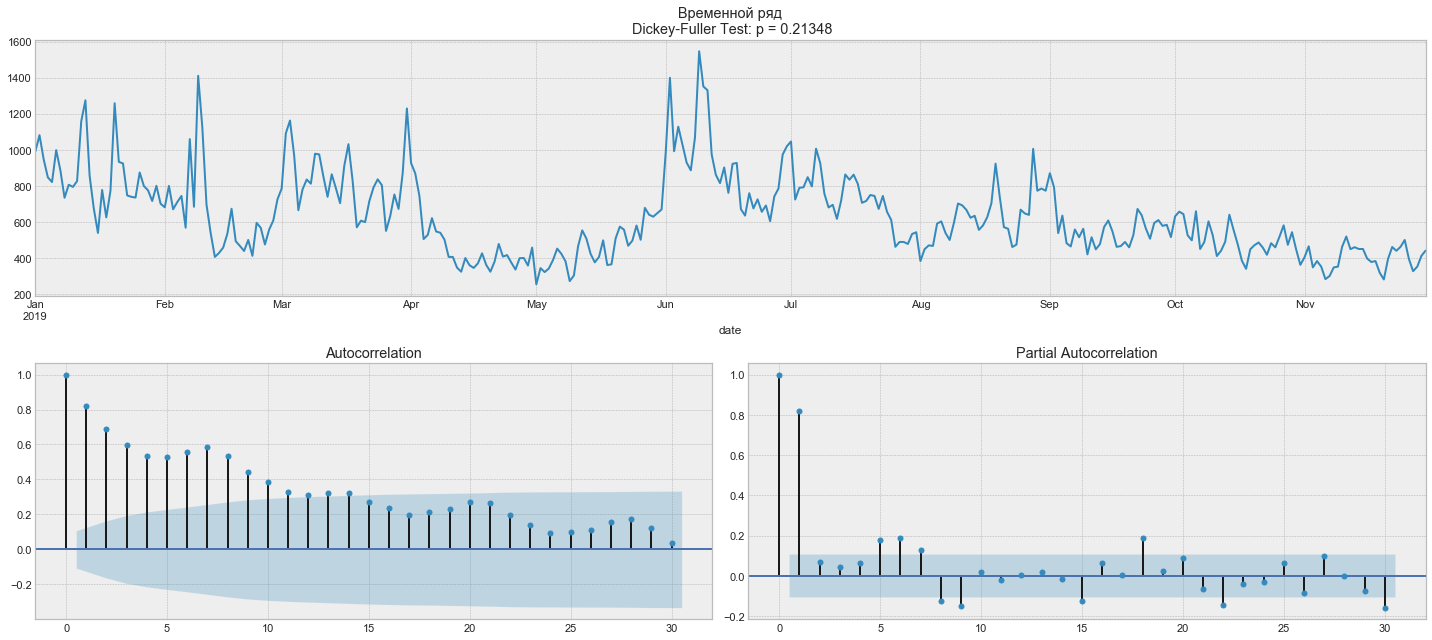

In [74]:
# Тест Дики-Фуллера на стационарность временного ряда, временной лаг 30 дней
tsplot(data.registeredUsers, lags = 30)

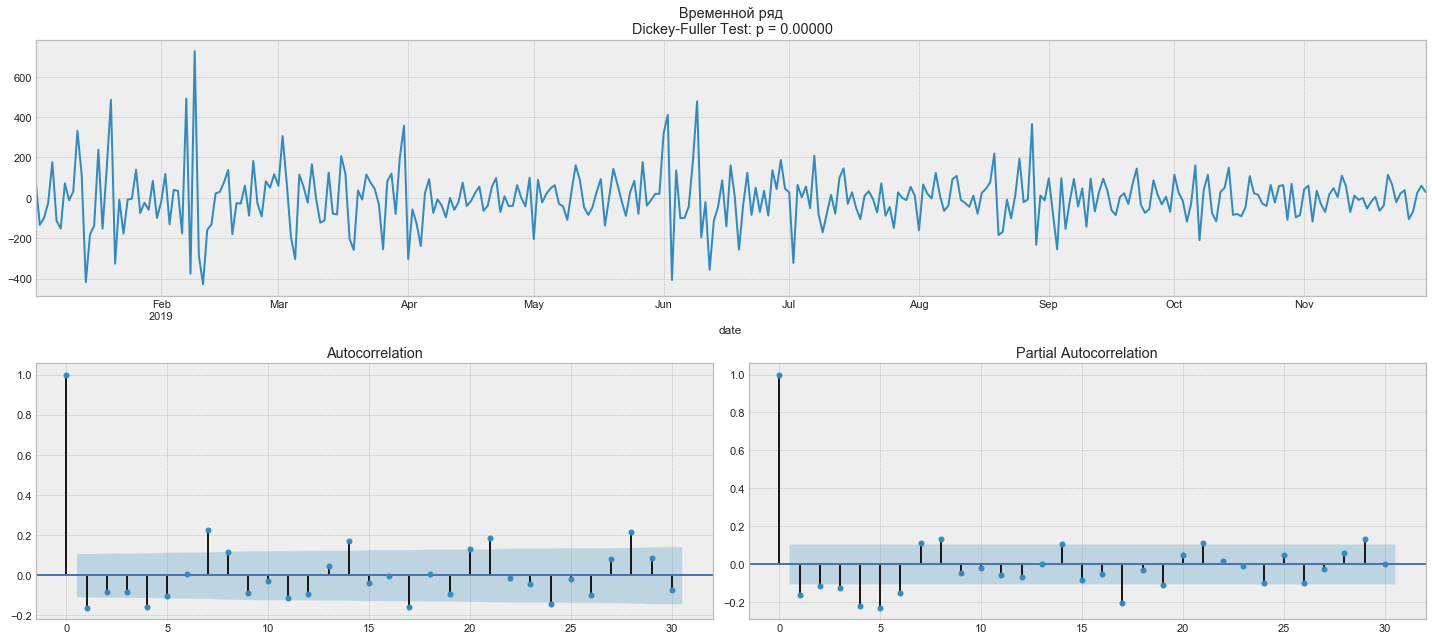

In [76]:
# Превращение временного ряда в стационарный процесс для предсказаний наблюдаемых величин
data_diff = data.registeredUsers - data.registeredUsers.shift(1)
tsplot(data_diff[1:], lags = 30)

## Построение модели SARIMA для предсказания временного ряда

In [77]:
# Первоначальные величины и границы временного ряда
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

# Комбинация вариаций различных параметров модели
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [78]:
# Обучение множества моделей SARIMA для нахождения оптимальной модели предсказания временного ряда
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Возвращает обратно датафрейм с параметрами и соответствующей функцией AIC
        
        parameter_list - list вместе с параметрами (p, q, P, Q) сетами
        d - порядок интегрирования величины
        D - порядок интегрированния сезонности
        s - длительность сезона
    """
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = sm.tsa.statespace.SARIMAX(data.registeredUsers, order = (param[0], d, param[1]),
                                               seasonal_order = (param[2], D, param[3], s)).fit(disp = -1)
        except:
            continue
            
        aic = model.aic
        
        # Сохранение и запись лучших параметров для модели (AIC и параметры)
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    
    # Соритировка данных по возрастающей, более низкий AIC (Akaike Information Criteria) самый лучший показатель
    result_table = result_table.sort_values(by = 'aic', ascending = True).reset_index(drop = True)
    
    return result_table


In [79]:
result_table = optimize_SARIMA(parameters_list, d, D, s)

In [80]:
# Установка параметров которые выдают наименбший показатель AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

In [82]:
best_model = sm.tsa.statespace.SARIMAX(data.registeredUsers, order = (p, d, q), seasonal_order = (P, D, Q, s)).fit(disp = -1)

In [83]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                   registeredUsers   No. Observations:                  334
Model:             SARIMAX(2, 1, 3)x(0, 1, 4, 5)   Log Likelihood               -2044.665
Date:                           Mon, 02 Dec 2019   AIC                           4109.330
Time:                                   18:50:39   BIC                           4147.260
Sample:                               01-01-2019   HQIC                          4124.463
                                    - 11-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2613      0.003    362.247      0.000       1.254       1.268
ar.L2         -0.9997      0.001  -1425.234

In [97]:

def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'CLOSE': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 5)
print(best_model.predict(start = data.registeredUsers.shape[0], end=data.registeredUsers.shape[0] + 30))
print(mean_absolute_percentage_error(data.registeredUsers[s + d:], best_model.fittedvalues[s + d:]))

2019-12-01    461.149460
2019-12-02    459.707231
2019-12-03    480.088505
2019-12-04    452.910348
2019-12-05    445.119433
2019-12-06    470.475499
2019-12-07    439.063141
2019-12-08    449.344650
2019-12-09    411.428348
2019-12-10    390.395583
2019-12-11    441.351097
2019-12-12    450.613641
2019-12-13    478.364771
2019-12-14    433.314440
2019-12-15    393.743999
2019-12-16    416.520761
2019-12-17    403.873438
2019-12-18    432.128407
2019-12-19    416.069702
2019-12-20    405.141505
2019-12-21    431.849014
2019-12-22    409.212825
2019-12-23    417.227536
2019-12-24    385.625831
2019-12-25    375.327094
2019-12-26    418.366277
2019-12-27    415.699541
2019-12-28    432.575025
2019-12-29    392.186463
2019-12-30    361.947316
2019-12-31    388.620088
Freq: D, dtype: float64
15.046222709650783
